In [1]:
import orcapod as op
from demo_setup.config import namespace_lookup, data_dir, store_dir, orch, client
import demo_setup.util as demo_util

## Orcapod DEMO

A framework for fully traceable and reproducible scientific computation

## Guiding Principles

- Reproducibility
- Performance
- Simplicity
- Flexibility
- Extensibility
- Reusability
- Robustness

## Monitors

In [2]:
# monitor active containers

# watch -n 0.5 docker ps -a


# monitor agent communication network

# clear && python -c 'import asyncio; import orcapod as op; client = op.AgentClient(group="demo", host="alpha"); asyncio.run(client.watch(key_expr="**"))'

## Setup test inputs

In [3]:
from pathlib import Path

In [4]:
input_dir = Path(namespace_lookup["default"]) / data_dir / "input"
input_dir.mkdir(parents=True, exist_ok=True)
for i in range(1, 16):
    (input_dir / f"{i}.txt").write_text(str(i))

## Define computation

`add_pod` -  Simple computation that:
- Add 2 numbers i.e. `left` + `right` => `answer`. 
- Sleep for 15s if `left` is `1`.
- Crash if `left` is equal to a value. Setting it to `110` will illustrate a successful pipeline run. Setting it to `10` will illustrate a failed pipeline run on `add_d`.

In [5]:
from textwrap import dedent

In [6]:
add_pod = op.Pod(
    image="python:alpine",
    command=[
        "sh",
        "-c",
        "umask u=rwx,g=rwx,o=rwx && python -c '{}'".format(
            dedent(
                """
                from pathlib import Path
                from time import sleep
                
                left = int(Path("/tmp/input/left.txt").read_text())
                right = int(Path("/tmp/input/right.txt").read_text())

                answer = left + right

                Path("/tmp/output/answer.txt").write_text(str(answer))

                if left == 110:
                    raise Exception("Intentionally crashing...")
                elif left == 1:
                    sleep(15)
                """
            ).strip()
        ),
    ],
    input_spec={
        "left": op.PathInfo(path="/tmp/input/left.txt", match_pattern=".*\.txt"),
        "right": op.PathInfo(path="/tmp/input/right.txt", match_pattern=".*\.txt"),
    },
    output_dir="/tmp/output",
    output_spec={"answer": op.PathInfo(path="answer.txt", match_pattern=".*\.txt")},
    source_commit_url="https://place.holder",
    recommended_cpus=0.1,
    recommended_memory=100 << 20,
)

## Run one-off compute job

In [7]:
add_pod_job = op.PodJob(
    pod=add_pod,
    input_packet=op.Packet(
        {
            "left": op.PathSet.UNARY(
                blob=op.Blob(
                    kind=op.BlobKind.FILE,
                    location=op.Uri(
                        namespace="default", path=f"{data_dir}/input/3.txt"
                    ),
                    checksum="",
                )
            ),
            "right": op.PathSet.UNARY(
                blob=op.Blob(
                    kind=op.BlobKind.FILE,
                    location=op.Uri(
                        namespace="default", path=f"{data_dir}/input/7.txt"
                    ),
                    checksum="",
                )
            ),
        }
    ),
    output_dir=op.Uri(namespace="default", path=f"{data_dir}/output/pod_adder"),
    cpu_limit=0.1,
    memory_limit=100 << 20,
    namespace_lookup=namespace_lookup,
)

In [8]:
pod_run = await orch.start(namespace_lookup=namespace_lookup, pod_job=add_pod_job)

In [9]:
pod_result = await orch.get_result(namespace_lookup=namespace_lookup, pod_run=pod_run)

In [10]:
await orch.delete(pod_run=pod_run)

## Define computational pipeline

Configuration for operator that renames packet keys i.e. `MapOperator`.

In [11]:
map_left = {"answer": "left"}
map_right = {"answer": "right"}

Compute pipeline that chains several `add_pod` computations.

In [12]:
pipeline = op.Pipeline(
    graph_dot="""
    digraph {
        add_a -> map_left_a
        add_b -> map_right_a
        add_c -> map_left_b
        add_d -> map_right_b
        { map_left_a map_right_a } -> cartesian_a -> add_e -> map_left_c
        { map_left_b map_right_b } -> cartesian_b -> add_f -> map_right_c
        { map_left_c map_right_c } -> cartesian_c -> add_g
    }
    """,
    metadata={
        **{
            f"add_{k}": op.Kernel.POD(ref=add_pod)
            for k in ["a", "b", "c", "d", "e", "f", "g"]
        },
        **{
            f"map_left_{k}": op.Kernel.MAP_OPERATOR(map=map_left)
            for k in ["a", "b", "c"]
        },
        **{
            f"map_right_{k}": op.Kernel.MAP_OPERATOR(map=map_right)
            for k in ["a", "b", "c"]
        },
        **{f"cartesian_{k}": op.Kernel.JOIN_OPERATOR() for k in ["a", "b", "c"]},
    },
    input_spec={
        **{
            f"left_add_{k}": [op.InputSpecUri(node=f"add_{k}", key="left")]
            for k in ["a", "b", "c", "d"]
        },
        **{
            f"right_add_{k}": [op.InputSpecUri(node=f"add_{k}", key="right")]
            for k in ["a", "b", "c", "d"]
        },
    },
    output_spec={"answer": op.OutputSpecUri(node="add_g", key="answer")},
)

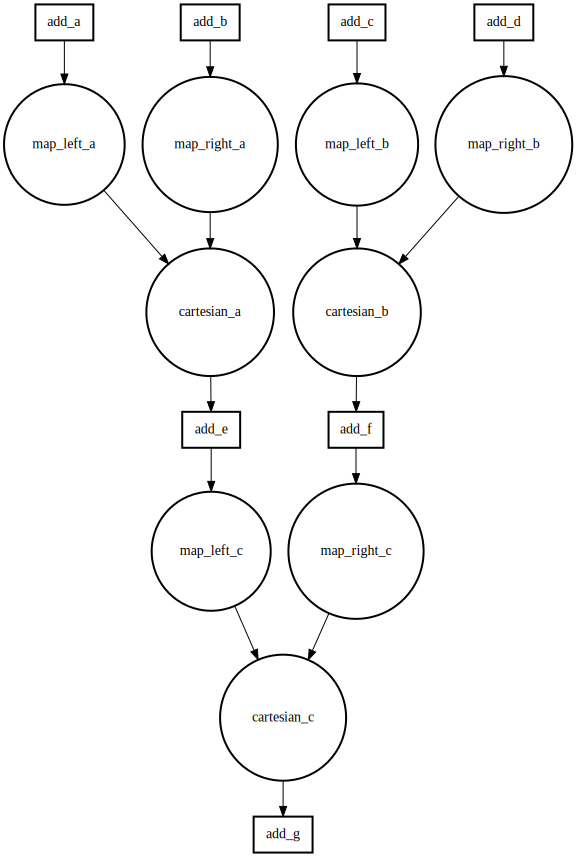

In [13]:
# print(pipeline.make_dot(with_style=False))
demo_util.display_dot(dot_data=pipeline.make_dot())

## Run computational pipeline job

In [14]:
from datetime import datetime, timezone

In [15]:
pipeline_job = op.PipelineJob(
    pipeline=pipeline,
    input_packet={
        "left_add_a": [
            op.PathSet.UNARY(
                blob=op.Blob(
                    kind=op.BlobKind.FILE,
                    location=op.Uri(
                        namespace="default",
                        path=f"{data_dir}/input/{i}.txt",
                    ),
                    checksum="",
                )
            )
            for i in range(1, 4)
        ],
        "right_add_a": [
            op.PathSet.UNARY(
                blob=op.Blob(
                    kind=op.BlobKind.FILE,
                    location=op.Uri(
                        namespace="default",
                        path=f"{data_dir}/input/{i}.txt",
                    ),
                    checksum="",
                )
            )
            for i in range(4, 6)
        ],
        **{
            k: [
                op.PathSet.UNARY(
                    blob=op.Blob(
                        kind=op.BlobKind.FILE,
                        location=op.Uri(
                            namespace="default",
                            path=f"{data_dir}/input/{i+6}.txt",
                        ),
                        checksum="",
                    )
                )
            ]
            for i, k in enumerate(
                [
                    "left_add_b",
                    "right_add_b",
                    "left_add_c",
                    "right_add_c",
                    "left_add_d",
                    "right_add_d",
                ]
            )
        },
    },
    output_dir=op.Uri(namespace="default", path=f"{data_dir}/output/pipeline_adder"),
    namespace_lookup=namespace_lookup,
)

In [16]:
# pipeline_job.input_packet()
pipeline_job.input_packet()["left_add_a"][0].blob.checksum

'6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b'

In [17]:
pipeline_run = await client.start_pipeline_job(pipeline_job=pipeline_job)

In [18]:
{
    "created": pipeline_run.created(),
    "status": pipeline_run.status(),
    "terminated": pipeline_run.terminated(),
}

{'created': 1762225171,
 'status': <PipelineStatus.RUNNING: 2>,
 'terminated': None}

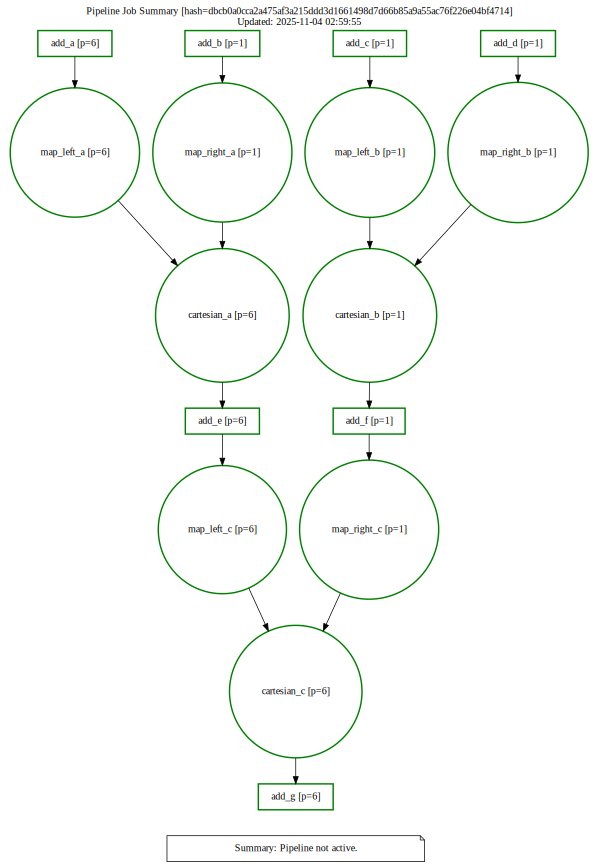

In [19]:
demo_util.animate_display(
    next_display_object=lambda: (
        demo_util.display_dot(dot_data=pipeline_run.summarize_dot())
        if not pipeline_run.terminated()
        or datetime.now(timezone.utc).timestamp() <= pipeline_run.terminated() + 2
        else None
    )
)

In [20]:
pipeline_result = await client.get_pipeline_result(pipeline_run=pipeline_run)

In [21]:
{
    "created": pipeline_result.created,
    "status": pipeline_result.status,
    "terminated": pipeline_result.terminated,
}

{'created': 1762225171,
 'status': <PipelineStatus.COMPLETED: 0>,
 'terminated': 1762225194}

In [22]:
# print(pipeline_run.summarize_dot())

## Roadmap

- Educational / Pitching Content
- Simpler, python-friendly experience
- Pipeline of pipelines
- Kubernetes orchestrator
- Queries and data exploration
- Dashboard GUIs
- Multi-agent support
- Tags
- Memoization
- Filter operator
- Agent resource limits
- Support external extensibility

## Teardown

In [23]:
import shutil
from pathlib import Path

In [24]:
shutil.rmtree(Path(namespace_lookup["default"]) / store_dir)
shutil.rmtree(Path(namespace_lookup["default"]) / data_dir)

In [25]:
# restart kernel between notebooks to shutdown active agent